# Импорт библиотек и вспомогательного кода

In [ ]:
from IPython.display import clear_output

!pip install torchmetrics[image]
!pip install lightning tbparse

clear_output()

In [ ]:
import os
import random
import torch

import numpy as np
import lightning as L
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tbparse import SummaryReader
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from torchvision.utils import make_grid
from PIL import Image
from pathlib import Path
from lightning.pytorch.callbacks import ModelCheckpoint
from tqdm import tqdm
from torchmetrics.image.inception import InceptionScore

In [ ]:
# basic random seed
def seed_basic(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


# torch random seed
def seed_torch(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# basic + torch + lightning
def seed_everything(seed=42):
    seed_basic(seed)
    seed_torch(seed)
    L.seed_everything(seed)


seed_everything()

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


# Задание 1. GAN для генерации точек

## Формат результата

1. Результаты экспериментов с изменением входного распределения и вывод по ним.
3. Модель, обученная для генерации выбранной вами фигуры, например, круга.

Пример генерации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX13/result_1_task_ex13.png" width="1000">

##  Модели генератора и дискриминатора
Определяем модели генератора и дискриминатора:

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_space, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
        )  # x,y

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # real/fake
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

## Датасет

Создадим датасет, который при инициализации генерирует точки параболы:

In [ ]:
class ParabolaDataset(Dataset):
    def __init__(self, n_samples=1000, noise=0.0):
        self.n_samples = n_samples
        self.noise = noise
        self.x = torch.FloatTensor(np.random.uniform(-1, 1, size=(n_samples)))
        self.y = torch.pow(self.x, 2) + torch.randn(n_samples) * noise

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return torch.stack((self.x[idx], self.y[idx]), 0), 0

Сгенерируем точки, посмотрим на них:

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


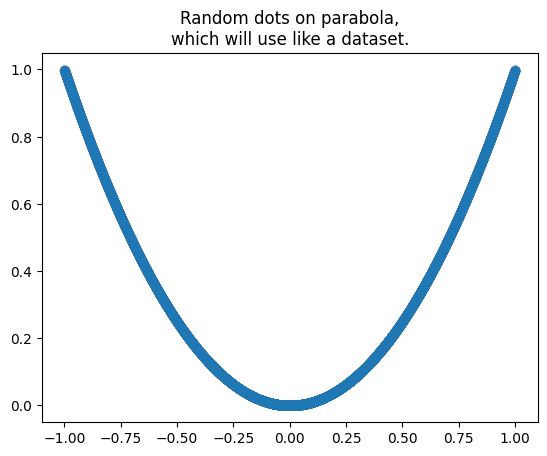

In [ ]:
seed_everything()

parabola = ParabolaDataset(n_samples=100000, noise=0)
plt.scatter(parabola.x, parabola.y, alpha=0.01)
plt.title("Random dots on parabola,\nwhich will use like a dataset.")
plt.show()

In [ ]:
parabola[0]

(tensor([-0.2509,  0.0630]), 0)

## Код обучения

Возьмем код визуализации из лекции:

In [ ]:
def test_image(pair_gen, pairs, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)
    plt.scatter(pairs[:, 0], pairs[:, 1], label="real")
    plt.scatter(pair_gen[:, 0], pair_gen[:, 1], label="generated")
    plt.axis([-1, 1, -1, 1])
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()


def visualization(log_dir):
    # visualization without TensorBoard for TensorBoard logs
    clear_output()
    reader = SummaryReader(log_dir)
    df = reader.scalars.drop_duplicates()

    uniq = set(df.tag.unique())
    uniq.remove("epoch")
    uniq = list(uniq)
    uniq.sort()

    i = 0
    ax_dict = {}
    for item in uniq:
        metric = item.split("/")[0] # log shoud have tag
        if metric not in ax_dict:
            ax_dict[metric] = i
            i += 1

    fig, axs = plt.subplots(len(ax_dict), 1, figsize=(12, 3.5 * len(ax_dict)))
    for item in uniq:
        metric = item.split("/")[0]
        if len(ax_dict)>1:
            ax = axs[ax_dict[metric]]
        else:
            ax = axs
        sub_df = df[df["tag"] == item]
        ax.plot(sub_df.step, sub_df.value, label=item)
        ax.set_ylabel(metric)
        ax.legend()
        ax.set_xlabel("iter")

    plt.grid()
    plt.show()

Код обучения модели:

In [ ]:
class GAN(L.LightningModule):
    def __init__(self, generator, discriminator, lr=3e-4, betas=(0.9, 0.999),
                 noise_function=torch.randn, latent_dim=5):
        super().__init__()
        self.automatic_optimization = False # for hand made settings

        self.generator = generator
        self.discriminator = discriminator
        self.criterion = nn.BCELoss()
        self.real_lable = 1.
        self.fake_lable = 0.
        self.lr = lr
        self.betas = betas
        self.noise_function = noise_function
        self.latent_dim = latent_dim

    def configure_optimizers(self):
        opt_gen = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.lr,
            betas=self.betas,
        )
        opt_disc = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.lr,
            betas=self.betas,
        )
        return [opt_gen, opt_disc], []

    def training_step(self, batch, batch_idx):
        self.real_items, _ = batch
        noises = self.noise_function(
            (self.real_items.shape[0], self.latent_dim),
            dtype=torch.float32,
        ).to(self.device)

        opt_gen, opt_disc = self.optimizers()
        # ---------------------
        # Train discriminator
        # ---------------------
        self.discriminator.zero_grad()
        # 1. discriminator on real items
        real_lable = torch.full(
            size=(self.real_items.shape[0], 1),
            fill_value=self.real_lable,
            dtype=torch.float,
        ).to(self.device)
        disc_lable = self.discriminator(self.real_items)
        loss_disc_real = self.criterion(disc_lable, real_lable)
        loss_disc_real.backward()

        # 2. discriminator on fake items
        fake_lable = torch.full(
            size=(self.real_items.shape[0], 1),
            fill_value=self.fake_lable,
            dtype=torch.float,
        ).to(self.device)
        self.fake_items = self.generator(noises)
        disc_lable = self.discriminator(self.fake_items)
        loss_disc_fake = self.criterion(disc_lable, fake_lable)
        loss_disc_fake.backward()

        # 3. discriminator optimizer step (on real and fake items)
        opt_disc.step()
        loss_disc = 0.5*loss_disc_real + 0.5*loss_disc_fake
        self.log("loss/disc", loss_disc, on_epoch=False, on_step=True)

        # ---------------------
        # Train generator
        # ---------------------
        self.generator.zero_grad()
        self.fake_items = self.generator(noises)
        disc_lable = self.discriminator(self.fake_items)
        loss_gen = self.criterion(disc_lable, real_lable)
        loss_gen.backward()

        opt_gen.step()
        self.log("loss/gen", loss_gen, on_epoch=False, on_step=True)

        if (batch_idx+1)%1000==0:
            visualization(self.logger.log_dir)
            test_image(
                self.fake_items.detach().cpu().numpy(),
                self.real_items.detach().cpu().numpy(),
                figsize=(12, 3.5),
            )

    def on_train_epoch_end(self):
        visualization(self.logger.log_dir)
        test_image(
            self.fake_items.detach().cpu().numpy(),
            self.real_items.detach().cpu().numpy(),
            figsize=(12, 3.5),
        )

## Изменение входного распределения

In [ ]:
seed_everything()

latent_dim = 5
batch_size = 32
hidden_dim = 50
epochs = 4

train_loader = DataLoader(
    parabola,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

generator = Generator(latent_dim, hidden_dim=hidden_dim)
discriminator = Discriminator(hidden_dim=hidden_dim)

pl_model = GAN(generator, discriminator, latent_dim=latent_dim)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Обучите GAN
(менять ничего не надо):

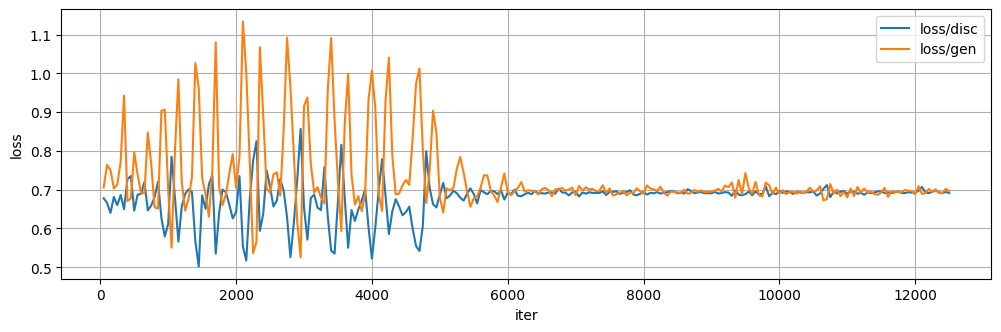

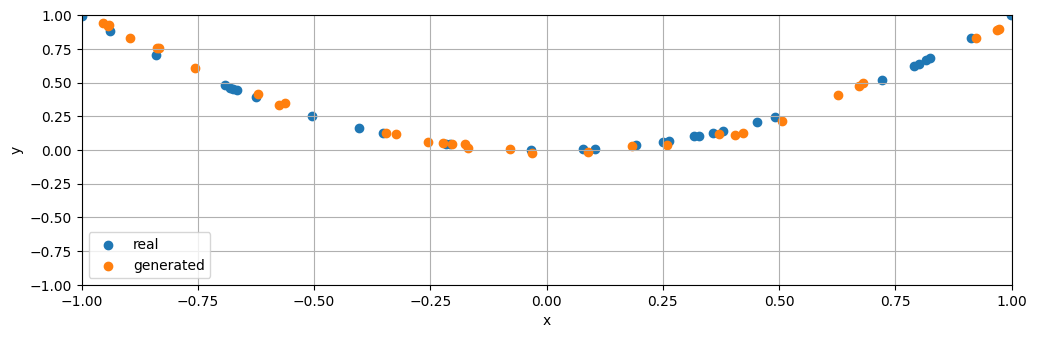

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


In [ ]:
trainer = L.Trainer(
    max_epochs=epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./z1/parabola/gaus/"),
)

trainer.fit(
    model=pl_model,
    train_dataloaders=train_loader
)

Попробуйте поменять входное распределение на **равномерное** и обучить модель:

In [ ]:
# Your code here
pl_model_rand = GAN(generator, discriminator, noise_function=torch.rand, latent_dim=latent_dim)

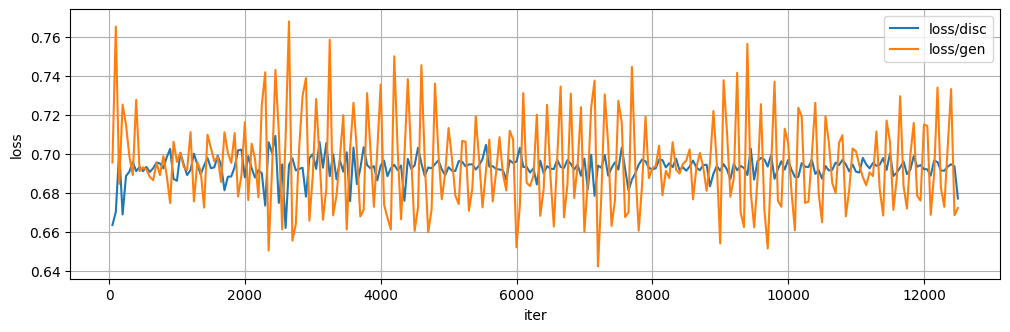

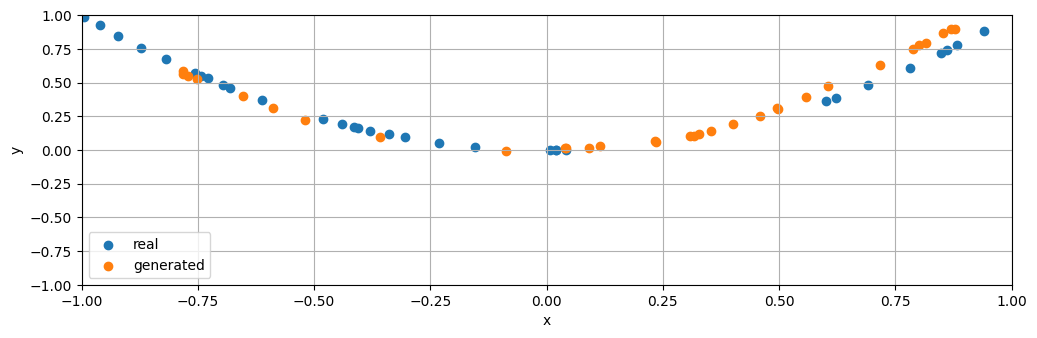

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


In [ ]:
trainer = L.Trainer(
    max_epochs=epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./z1/parabola/rand/"),
)

trainer.fit(
    model=pl_model_rand,
    train_dataloaders=train_loader
)

Сделайте входное распределение **равномерным на промежутке от -0.5 до 0.5.**

In [ ]:
torch.rand

<function torch._VariableFunctionsClass.rand>

In [ ]:
def noise_func(shape, dtype=torch.float32):
    return torch.rand(shape, dtype=dtype) - 0.5

In [ ]:
# Your code here
pl_model_rand_2 = GAN(generator, discriminator, noise_function=noise_func, latent_dim=latent_dim)

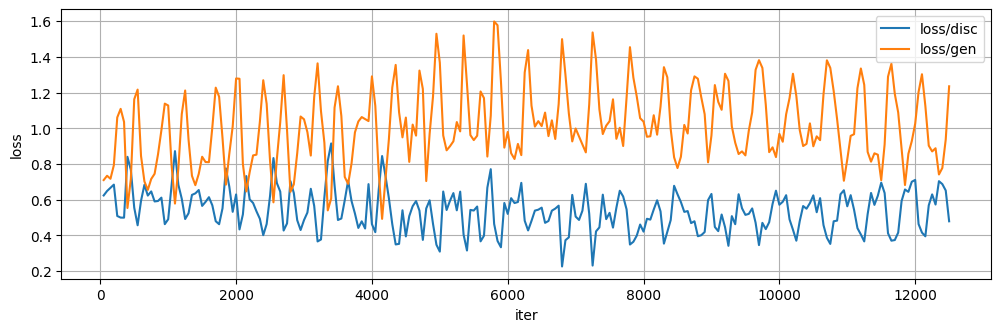

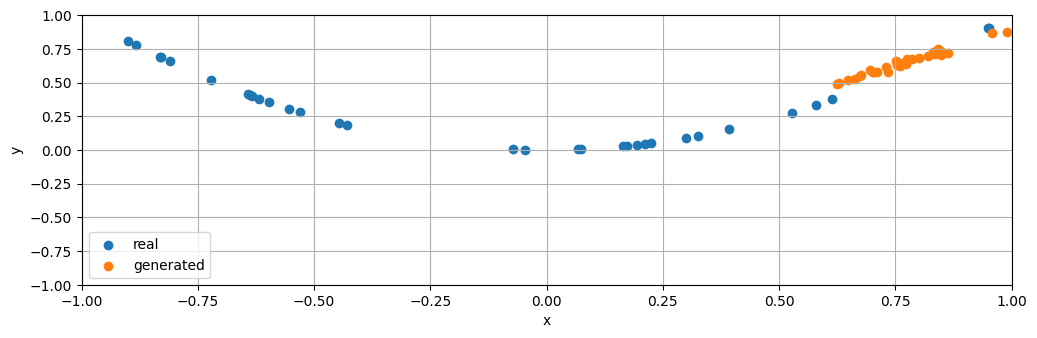

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


In [ ]:
trainer = L.Trainer(
    max_epochs=epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./z1/parabola/rand_2/"),
)

trainer.fit(
    model=pl_model_rand_2,
    train_dataloaders=train_loader
)

Напишите вывод о зависимости генерации от входного распределения.

**Напишите вывод:**
Сходимость GANов и результат генерации зависят от входного распределения: при нормальном распределении наблюдается отличная сходимость, чуть похуже при равномерном распределении от 0 до 1. При равномерном распределении на промежутке от -0.5 до 0.5 не удалось достичь сходимости, и результат генерации представляет собой не параболу, а просто кластер точек.

## Изменение генерируемых данных

Сделайте генерацию фигуры более сложной формы (например, круга).

In [ ]:
class CircleDataset(Dataset):
    def __init__(self, n_samples=1000, noise=0.0):
        self.n_samples = n_samples
        self.noise = noise
        self.t = torch.FloatTensor(np.random.uniform(-1, 1, size=(n_samples)))
        self.x = torch.cos(5*self.t)
        self.y = torch.sin(5*self.t) #+ (torch.abs(torch.cos(self.t)) ** 0.5)

        #self.x = 16 * torch.sin((self.t ** 3)) #+ torch.randn(n_samples) * noise
        #self.y = 13 * torch.cos(self.t) - 5 * torch.cos(2 * self.t) - 2 * torch.cos(self.t) - torch.cos(4 * self.t)#+ torch.randn(n_samples) * noise

        #self.t = torch.FloatTensor(np.random.uniform(0, 1, size=(n_samples)))
        #self.x = 2*torch.sin(10*self.t)
        #self.y = torch.sin(2*10*self.t)# Your code here
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return torch.stack((self.x[idx], self.y[idx]), 0), 0

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


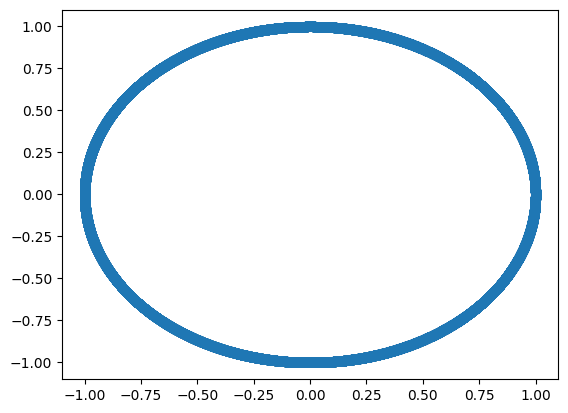

In [ ]:
seed_everything()

circle = CircleDataset(n_samples=100000, noise=0)
plt.scatter(circle.x, circle.y)

In [ ]:
seed_everything()

latent_dim = 5
batch_size = 32
hidden_dim = 50
epochs = 4

train_loader = DataLoader(
    circle,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

generator = Generator(latent_dim, hidden_dim=hidden_dim)
discriminator = Discriminator(hidden_dim=hidden_dim)

pl_model_circle = GAN(generator, discriminator, latent_dim=latent_dim)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Обучите GAN
(менять ничего не надо):

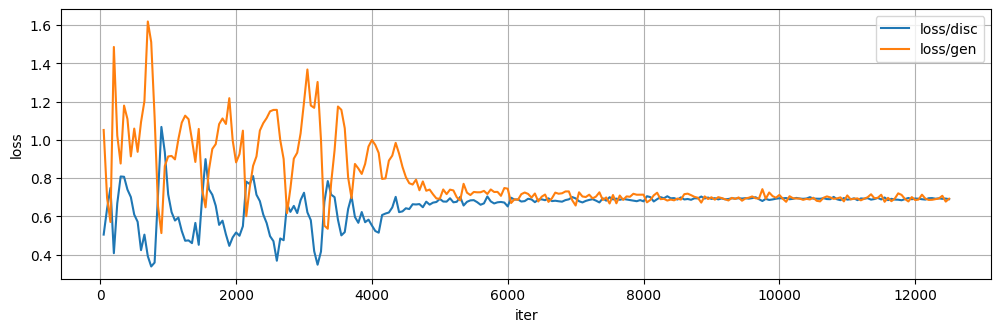

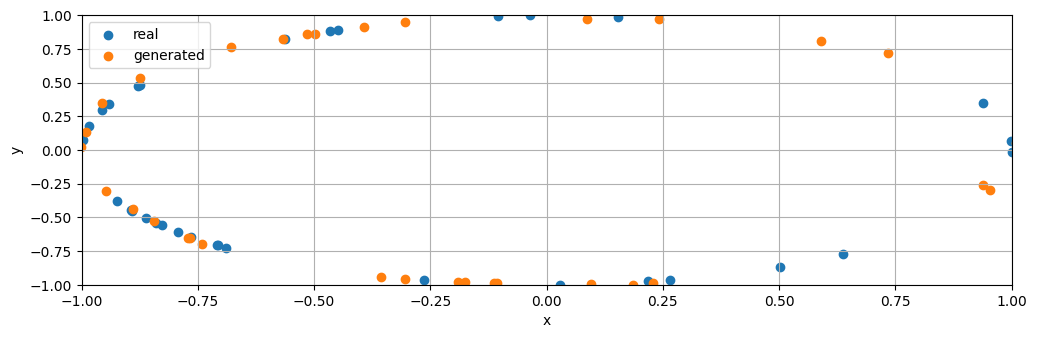

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


In [ ]:
trainer = L.Trainer(
    max_epochs=epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./z1/figure/uniform/"),
)

trainer.fit(
    model=pl_model_circle,
    train_dataloaders=train_loader
)

# Задание 2. This Galaxy doesn't exist (Conditional GAN)

В этом задании мы используем Conditional GAN для того, чтобы создавать галактики, которых никогда не существовало. Для этого воспользуемся датасетом [`Galaxy10`](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html). Galaxy10 — датасет, содержащий 21785 центрированных цветных (RGB) изображений галактик, с размерами 207×207, разделенных на 10 классов.

Выбор архитектуры генератора и дискриминатора — ресурсоемкая задача, поэтому этот код за вас написан. Ваша задача — дописать код обучения Conditional GAN и получить реалистичные изображения.

## Формат результата

- Сгенерированные галактики,
- Значения `InceptionScore`,
- Вывод.

Пример генерации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX13/result_2_task_ex13.png" width="800">

## Датасет

In [ ]:
!pip install astronn -q

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context  # ignore url error

In [ ]:
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup

import numpy as np
from sklearn.model_selection import train_test_split

images, labels = load_galaxy10()

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1)
train_images, train_labels = images[train_idx], labels[train_idx],
test_images, test_labels = images[test_idx], labels[test_idx]

/root/.astroNN/datasets/Galaxy10_DECals.h5 was found!


В датасете Galaxy10 есть 10 классов изображений.

In [ ]:
from astroNN.datasets.galaxy10 import Galaxy10Class

print(Galaxy10Class)

{0: 'Disturbed', 1: 'Merging', 2: 'Round Smooth', 3: 'Smooth, Cigar shaped', 4: 'Cigar Shaped Smooth', 5: 'Barred Spiral', 6: 'Unbarred Tight Spiral', 7: 'Unbarred Loose Spiral', 8: 'Edge-on without Bulge', 9: 'Edge-on with Bulge'}


 Выведем по одному изображению из каждого класса

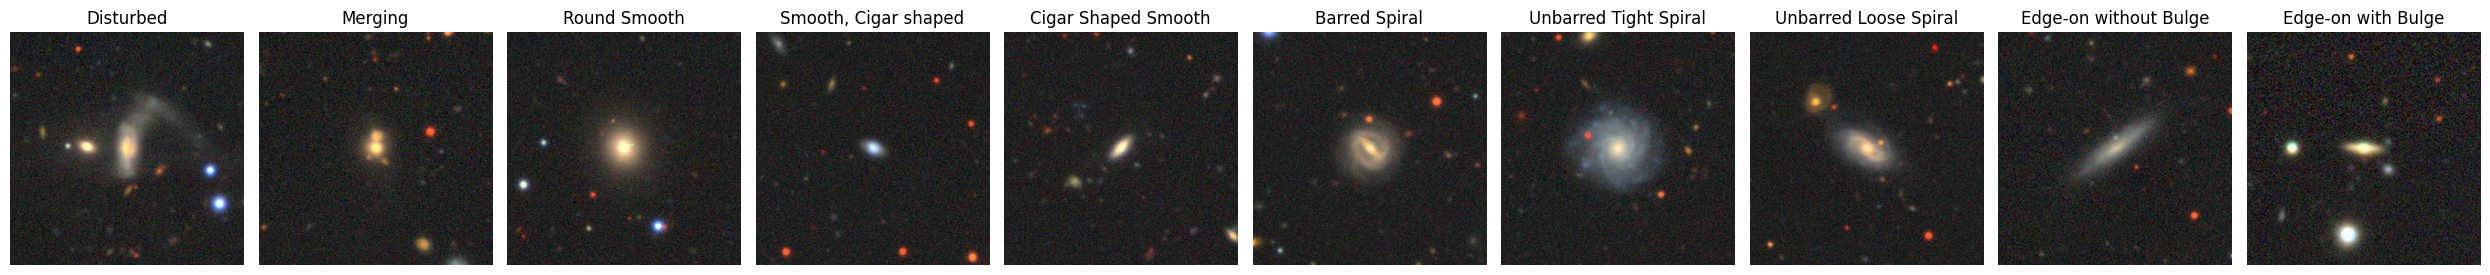

In [ ]:
import matplotlib.pyplot as plt


def show_samples(images, titles=[]):
    fig, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(25, 15))
    for i, img in enumerate(images):
        ax[i].imshow(img)
        if len(titles) > i:
            ax[i].set_title(titles[i])
        ax[i].axis("off")
    plt.tight_layout()


# Get fist image in class along with class index
class_num, first_indx = np.unique(labels, return_index=True)
samples = images[first_indx]
class_names = list(Galaxy10Class.values())
show_samples(samples, class_names)

Cоберем датасет из этих изображений

In [ ]:
from torch.utils.data.dataset import Dataset


class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, indx):
        image = self.images[indx]
        label = self.labels[indx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

## Предобработка

RGB-каналы изображений принимают значения **от 0 до 1**. Мы можем обеспечить этот диапазон значений, разместив на выходе генератора **сигмоиду**.

При этом на **дискриминатор**, который является классификатором, лучше подавать **нормализованные изображения**.

Посчитаем статистику по RGB-каналам. Считать std как среднее от стандартных отклонений по batch-ам некорректно. Поэтому используем [источник](https://stackoverflow.com/questions/10365119/mean-value-and-standard-deviation-of-a-very-huge-data-set).

In [ ]:
from tqdm import tqdm


def get_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=512 * 4, shuffle=False)
    sum_channel = 0
    squared_sum_channel = 0
    n = len(dataset) * dataset[0][0].shape[1] * dataset[0][0].shape[2]
    for images, lables in tqdm(loader):
        # sum of values
        sum_channel += images.sum(dim=(0, 2, 3))
        # sum of squared values
        squared_sum_channel += images.pow(exponent=2).sum(dim=(0, 2, 3))
    mean = sum_channel / n  # E[x]
    std = (squared_sum_channel / n - mean**2).sqrt()  # E[x^2] - (E[X])^2
    return mean.numpy(), std.numpy()

Мы будем генерировать изображения 64×64. Сделаем Resize и добавим случайные повороты на количество градусов, кратное 90.

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(64, antialias=True),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
    ]
)

dataset = GalaxyDataset(train_images, train_labels, transform)

Посчитаем статистику для нормализации для дискриминатора (поворот на нее не влияет) и создадим нормализатор.

In [ ]:
mean, std = get_mean_and_std(dataset)
normalize = transforms.Normalize(mean, std)

100%|██████████| 8/8 [00:37<00:00,  4.71s/it]


## Условный генератор

Чтобы из обычного GANа сделать cGAN, нам нужно как-то подмешать в латентный вектор метку класса. Для этого нужно преобразовать метки классов `labels` в вид, с которым умеет работать нейросеть, и, сформировав `embedding`, подмешать в `inputs`.

Код для вас уже написан, изучите его, обратив внимание на размерность входов и размерность и диапазон выходных значений.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
from torch import nn


class CGenerator(nn.Module):
    """
    Conditional Generator
    Args:
        latent_dim (int): latent space size
        image_size (int): size of the image
        channels (int): channels of the image
        num_classes (int): number of classes for dataset
    """

    def __init__(
        self,
        latent_dim: int = 10,
        image_size: int = 64,
        channels: int = 3,
        num_classes: int = 10,
    ) -> None:
        super().__init__()
        self.image_size = image_size
        self.channels = channels
        self.latent_dim = latent_dim

        # noise transform
        self.init_size = self.image_size // 4
        self.noise_transform = nn.Linear(latent_dim, 128*self.init_size**2)

        # embedding for condition
        self.label_embedding = nn.Embedding(num_classes, 128*self.init_size**2)

        # convolution part
        self.main = nn.Sequential(
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, inputs: torch.Tensor, labels: list = None) -> torch.Tensor:
        """
        Args:
            inputs (tensor): input tensor into the calculation.
            labels (tensor):  input tensor label.
        Returns:
            A four-dimensional tensor (batch*C*H*W).
        """

        inputs = self.noise_transform(inputs)  # [batch x 127*init_size*init_size]
        labels = labels.type(torch.LongTensor).to(inputs.device)
        #labels = torch.from_numpy(labels).to(inputs.device)
        embedding = self.label_embedding(labels.view((-1, 1))).view(
            -1,  128*self.init_size**2
        )# [batch x 128*init_size*init_size]

        inputs = torch.cat((inputs, embedding), dim=1).view(
            (-1, 256, self.init_size, self.init_size)
            # [batch x (128+128) x init_size x init_size]
        )
        return self.main(inputs)

Быстрый тест

In [ ]:
net_g = CGenerator()
noise = torch.randn(1, 10)
lable = torch.tensor([0])
img = net_g(noise, lable)
print(img.shape)

torch.Size([1, 3, 64, 64])


## Условный дискриминатор

В класическом cGAN метку класса подмешивают и к дискриминатору.

Код для вас уже написан, изучите его, обратив внимание на размерность входов и размерность и диапазон выходных значений.

In [ ]:
class CDiscriminator(nn.Module):
    """
    Conditional Discriminator
    Args:
        image_size (int): size of the image
        channels (int): channels of the image
        num_classes (int): number of classes for dataset
    """

    def __init__(
        self, image_size: int = 64, channels: int = 3, num_classes: int = 10
    ) -> None:
        super().__init__()

        self.embedding_size = image_size // 16
        self.label_embedding = nn.Embedding(num_classes, self.embedding_size**2)

        def discriminator_block(in_filters, out_filters):
            block = nn.Sequential(
                nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.BatchNorm2d(out_filters, 0.8),
            )
            return block

        self.main = nn.Sequential(
            discriminator_block(channels, 16),
            discriminator_block(16, 32),
            discriminator_block(32, 64),
            discriminator_block(64, 127),
            nn.Flatten(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * self.embedding_size**2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs: torch.Tensor, labels: list = None) -> torch.Tensor:
        """
        Defines the computation performed at every call
        Args:
            inputs (tensor): input tensor into the calculation
            labels (tensor): input tensor label
        Returns:
            A 2-dimensional tensor [batch x 1]
        """
        inputs = self.main(inputs)  # [batch x 127*embedding_size**2]
        labels = labels.type(torch.LongTensor).to(inputs.device)
        #labels = torch.from_numpy(labels).to(inputs.device)
        embedding = self.label_embedding(labels.view((-1, 1))).view(
            (-1, self.embedding_size**2)
        )# [batch x 1*embedding_size**2]

        inputs = torch.cat(
            (inputs, embedding), dim=1
        )  # [batch x 128*embedding_size**2]
        return self.classifier(inputs)

In [ ]:
type(labels)

torch.Tensor

Быстрый тест

In [ ]:
net_d = CDiscriminator()
img = torch.randn(1, 3, 64, 64)
lable = torch.tensor([0])
ans = net_d(img, lable)
print(ans.shape)

torch.Size([1, 1])


## Обучение
Вам необходимо реализовать код для обучения.

In [ ]:
def test_image(fake_items, real_items, figsize=(5, 5)):
    grid_fake = make_grid(
        torch.tensor(fake_items[:10]),
        nrow=10,
        normalize=True
    ).permute(1, 2, 0).numpy()

    grid_real = make_grid(
        torch.tensor(real_items[:10]),
        nrow=10,
        normalize=True
    ).permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(2, 1, figsize=figsize)
    ax[0].imshow(grid_fake)
    ax[0].set_axis_off()
    ax[1].imshow(grid_real)
    ax[1].set_axis_off()
    plt.axis("off")
    plt.show()

In [ ]:
class СGAN(GAN):
    def __init__(self, net_generator, net_discriminator, lr=3e-4, betas=(0.5, 0.999),
                 noise_function=torch.randn, latent_dim=10):
        super().__init__(
            generator, discriminator, lr, betas, noise_function, latent_dim
        )
        # metrics
        self.is_real = InceptionScore()
        self.is_fake = InceptionScore()

        self.data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.lr = lr
        self.epochs = epochs
        self.betas = betas
        # init discriminator
        self.net_discriminator = net_discriminator
        self.optimizer_discriminator = torch.optim.Adam(
            self.net_discriminator.parameters(), lr=self.lr, betas=self.betas
        )

        # init generator
        self.net_generator = net_generator
        self.optimizer_generator = torch.optim.Adam(
            self.net_generator.parameters(), lr=self.lr, betas=self.betas
        )

        # init criterion
        self.criterion = nn.BCELoss()

        # for eval
        #self.noise_function = torch.randn(
        #    (10, self.net_generator.latent_dim)
        #)
        self.fixed_conditional = torch.LongTensor([*range(10)])


    def __call__(self):

        for epoch in range(self.epochs):
            self.net_discriminator.train()
            self.net_generator.train()

            for i, (input, target) in enumerate(self.data_loader):
                input, target = input, target.type(torch.LongTensor)
                batch_size = input.shape[0]

                self.net_discriminator.zero_grad()

                # 1. Run with real data
                # The real sample label is 1
                real_label = torch.ones((batch_size, 1))
                output_real = self.net_discriminator(input, target)
                d_loss_real = self.criterion(output_real, real_label)
                d_loss_real.backward()

                # 2. Run with fake data
                # The generated sample label is 0
                fake_label = torch.zeros((batch_size, 1))
                # Noise for generation
                noise = torch.randn(
                    (batch_size, self.net_generator.latent_dim)
                )
                fake_points = self.net_generator(noise, target)
                output_fake = self.net_discriminator(fake_points.detach(), target)
                d_loss_fake = self.criterion(output_fake, fake_label)
                d_loss_fake.backward()


                # 3. Optimization step
                d_loss = (d_loss_real + d_loss_fake) / 2
                self.optimizer_discriminator.step()
                self.net_generator.zero_grad()
                output_g = self.net_discriminator(fake_points, target)
                g_loss = self.criterion(output_g, real_label)
                g_loss.backward()

                self.optimizer_generator.step()
                # Your code here

            self.eval()
        self.net_discriminator.to("cpu")
        self.net_generator.to("cpu")

    def eval(self):
        with torch.no_grad():
            # Switch model to eval mode
            self.net_generator.eval()
            img_tensor = self.net_generator(
                self.noise_function.detach.cpu().numpy(),
                self.fixed_conditional,
            )
            img_tensor = img_tensor.cpu().detach()
            img_grid = make_grid(img_tensor, nrow=5).type(torch.float).permute(1, 2, 0).numpy()
    # Your code here


In [ ]:
torch.cuda.empty_cache()

In [ ]:
seed_everything()

batch_size = 32
epochs = 10

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def add_spectral_norm(m):
    if isinstance(m, nn.Linear) or isinstance(m, torch.nn.Conv2d):
        m = spectral_norm(m)

generator = CGenerator()
discriminator = CDiscriminator()
discriminator.apply(add_spectral_norm)

pl_model = СGAN(generator, discriminator)

trainer = L.Trainer(
    max_epochs=epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./z2/"),
)

trainer.fit(
    model=pl_model,
    train_dataloaders=data_loader
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type           | Params
---------------------------

Training: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'type'

## Тест

Рассчитайте  `InceptionScore` для отложенной выборки с сгенерированных данных.

In [ ]:
# Your code here

Является ли  `InceptionScore` “из коробки” хорошей метрикой для датасета Galaxy10? Что можно сделать для улучшения метрики?

**Напишите вывод** с ответом на вопросы выше:


# Задание 3*. Classifier-free guidance для диффузионных моделей генерации

В ходе лекции мы рассмотрели диффузионную модель генерации изображений галактик. В рамках данного задания вам предлагается попробовать сделать модель "условной", то есть научиться генерировать при помощи диффузионных моделей объекты определенного класса.

Существуют различные подходы к добавлению "условия" в диффузионную модель. Реализуем наиболее простой подход, связанный с добавлением метки класса в модель предсказания шума.

## Формат результата

Набор чисел от 0 до 9, сгенерированных моделью.

Пример генерации:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX13/result_3_task_ex13.png" width="800">

## Датасет

Как известно, диффузионные модели требуют большое количество вычислительных ресурсов для обучения. Попробуем упросить задачу, взяв в качестве датасета сравнительно простой MNIST:

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

root = "./data"

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = MNIST(root=root, train=True, transform=transform, download=True)
clear_output()

## Структурные блоки

Структурные блоки возьмем из лекции (для экономии времени на обучение мы уберем блоки `SelfAttention`):


In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_features, out_features, mid_features=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_features:
            mid_features = out_features
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_features, mid_features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_features),
            nn.GELU(),
            nn.Conv2d(mid_features, out_features, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_features),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_stack(x))
        else:
            return self.conv_stack(x)

class ResizeBlock(nn.Module):
    def __init__(self, in_features, out_features, emb_dim):
        super().__init__()
        # defines non-linear map from time embedding features to conv features
        self.emb_projection = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_features),
        )

    def add_emb(self, x, t_vector):
        #[batch_size, time_embedding_dim] -> [batch_size, out_features]
        emb = self.emb_projection(t_vector)
        # [batch_size, out_features] - > [batch_size, out_features, H, W]
        emb = emb[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

    def forward(self, x):
        pass


class Down(ResizeBlock):
    def __init__(self, in_features, out_features, emb_dim=256):
        super().__init__(in_features, out_features, emb_dim)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ResNetBlock(in_features, in_features, residual=True),
            ResNetBlock(in_features, out_features),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        x = self.add_emb(x, t)
        return x


class Up(ResizeBlock):
    def __init__(self, in_features, out_features, emb_dim=256):
        super().__init__(in_features, out_features, emb_dim)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            ResNetBlock(in_features, in_features, residual=True),
            ResNetBlock(in_features, out_features, in_features // 2),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        x = self.add_emb(x, t)
        return x

## Conditional denoising U-Net

Процедура добавления меток классов для диффузионных моделей подробно рассмотрена в [данной публикации](https://arxiv.org/pdf/2207.12598.pdf). Она сводится к следующим пунктам. Мы постараемся максимально упростить архитектуру, чтобы обучить модель в рамках семинара. Основные отличия модели:

- Модель определения шума принимает не только батч изображений и батч индексов времени диффузионного процесса, но и метки класса.

  То есть исходное описание класса
  ```
  class UNet(nn.Module):

    ...
    def forward(self, x):
       ...

  ```
  
  заменено на:
```
class UNet(nn.Module):

    ...
    def forward(self, x, t, y=None):
       ...
```

- Во время обучения условной модели мы хотим подавать в неё батчи как с метками класса, так и без них. Чтобы добиться этого, рекомендуем использовать блок `nn.Embedding`, установив размерность выхода равной `time_embed_dim`. Выход `nn.Embedding` должен суммироваться с `pos_encoding`, когда `y` не `None`. Реализуйте это на месте `# Your code here`.

Для ускорения процесса обучения мы упростили модель "расшумляющего U-Net". Вы не ограничены в выборе только описанной в лекции модели и можете реализовать собственную U-Net подобную архитектуру или воспользоваться этой.

In [ ]:
class UNet(nn.Module):
    r'''
    Denoising U-Net model implementation based on arXiv:2006.11239 [cs.LG]
    '''
    def __init__(self, num_channels=1, img_size=28, time_embed_dim=256):
        super().__init__()
        self.num_channels = num_channels
        self.time_dim = time_embed_dim
        self.img_size = img_size

        # class embedding
        # Your code here

        # Downsample and enlarge feature dim
        self.inc = ResNetBlock(num_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 32)

        # Keep spatial dim constant
        self.conv_bottleneck = nn.Sequential(
                ResNetBlock(32, 64),
                ResNetBlock(64, 32)
        )

        # Upsample and reduce feature dim
        # 256=128+128 from conv_bottleneck and sa2
        self.up1 = Up(64, 16)
        # 128=64+64 from sa4 and sa1
        self.up2 = Up(32, 16)
        self.outc = nn.Conv2d(16, num_channels, kernel_size=1)


    def pos_encoding(self, t):
        r"""
        Returns embedding vector for given integer time index.

        We adopt 1d Positional Encoding form arXiv:1706.03762 [cs.CL]
        see 3.5 for more details.

        PE(x,2i) = sin(x/10000^(2i/D))
        PE(x,2i+1) = cos(x/10000^(2i/D))

        Where:
        x is a point in 1d space
        i is an integer in [0, D/2), where D is the size of the feature dimension

        Args:
            t: Tensor, shape ``[batch_size, 1]``
        Returns:
            pe: Tensor, shape ``[batch_size, time_embedding_dim]``
        """

        # placeholder for diffusion time encoding vector
        pe = torch.zeros(t.shape[0], self.time_dim).to(t)

        # factor 1/10000^(2i/D)
        div_factors = torch.exp(
        torch.arange(0, self.time_dim, 2)
        * (-torch.log(torch.as_tensor(10000.0)) / self.time_dim)
        ).to(t)

        # repeat t index for each feature
        x = t.repeat(1, self.time_dim // 2)

        # sin(x/10000^(2i/D)) for even features
        pe[:, 0::2] = torch.sin(x * div_factors)
        # cos(x/10000^(2i/D)) for odd features
        pe[:, 1::2] = torch.cos(x * div_factors)

        return pe

    def forward(self, x, t, y = None):
        t = t.unsqueeze(-1).type(torch.float).to(x)
        t = self.pos_encoding(t)

        if y is not None:
          # Your code here


        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)

        x3 = self.conv_bottleneck(x3)

        x = self.up1(x3, x2, t)
        x = self.up2(x, x1, t)
        output = self.outc(x)
        return output

## Обучение модели

Во время обучения нам необходимо увеличивать количество батчей данных, где мы учитываем метки класса. На первой эпохе обучения необходимо показывать модели метки класса с вероятностью $0$, а на последней эпохе обучения, наоборот, все метки классов должны быть переданы модели. Для этого нам нужно модифицировать класс диффузионной модели, добавив методу шага обучения возможность передавать или не передавать метки класса в модель.

Предлагаем линейно увеличивать вероятность добавления метки класса от $0$ до $1$ от эпохи к эпохе. Для этого вам может пригодиться функция `np.random.choice`, информация о текущей эпохе `self.current_epoch` и информация о максимальном количестве эпох `self.trainer.max_epochs`. Реализуйте код в точке `# Your code here`.

In [ ]:
class DiffusionGenerativeModel(L.LightningModule):
    def __init__(
        self, model, path,
        num_noise_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        img_size=28,
        lr=0.001,
        save_images=False,
        save_progress=False,
    ):
        super().__init__()
        self.model = model
        self.path = Path(path)
        self.num_noise_steps = num_noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.lr = lr
        self.save_images = save_images
        self.save_progress = save_progress

        # diffusion process linear noise schedule
        self.beta = self._get_noise_schedule()
        self.alpha = 1.0 - self.beta
        # \hat{\alpha}_{i-1} = \prod_{j=0}^{i-1} \alpha_j
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        # init optimizer and loss for training
        self.criterion = nn.MSELoss()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        return optimizer

    def _get_noise_schedule(self):
        return torch.linspace(
            self.beta_start, self.beta_end, self.num_noise_steps
        )

    def _noise_images_batch(self, x, t):
        # \mu_i = \sqrt{\hat{\alpha}_i}
        mu = torch.sqrt(self.alpha_hat[t])[:, None, None, None].to(self.device)
        # \sigma_i = \sqrt{1 - \hat{\alpha}_i}
        sigma = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None].to(self.device)

        standard_normal_noise = torch.randn_like(x).to(self.device)
        noised_image_batch = mu * x + sigma * standard_normal_noise
        return noised_image_batch, standard_normal_noise

    def _get_timestams_batch(self):
        return torch.randint(
            low=1, high=self.num_noise_steps, size=(self.batch_size,)
        )

    def generate_images_batch(self, labels=None):
        # start from pure noise batch
        x = torch.randn((self.batch_size, 1, self.img_size, self.img_size)).to(self.device)
        # and apply self.num_noise_steps denoising steps with model
        for t_i in tqdm(reversed(range(1, self.num_noise_steps)), position=0):
            # Build tensor with timestamp index. Same for each element in batch
            t = torch.full((self.batch_size,), t_i).long().to(self.device)
            if labels is None:
                labels = torch.randint(
                    low=0, high=10, size=(self.batch_size,)
                ).long().to(self.device)
            else:
                labels = labels.long()
            # predict noise on current timestamp
            with torch.inference_mode():
                pred_noise = self.model(x, t, labels).detach()

            # restore noise parametrs on current timestamp
            alpha = self.alpha[t.to('cpu')][:, None, None, None].to(self.device)
            alpha_hat = self.alpha_hat[t.to('cpu')][:, None, None, None].to(self.device)
            beta = self.beta[t.to('cpu')][:, None, None, None].to(self.device)

            # partialy denoise batch of images
            x = x - (1.0 - alpha) / (1 - alpha_hat).sqrt() * pred_noise
            x = (1 / alpha.sqrt()) * x

            if self.save_progress and t_i%20==0:
                prog_x = x.clamp(0, 1)
                prog_x = (prog_x * 255).type(torch.uint8)
                self._save_img(
                    imgs=prog_x,
                    path=self.path/"progress"/f"{t_i}.jpg"
                )
            # add appropriate amount of noise for next step if any
            if t_i > 0:
                z = torch.randn_like(x).to(self.device)
                x = x + beta.sqrt() * z

        # clip x to valid 0..255 image range
        x = x.clamp(0, 1)
        x = (x * 255).type(torch.uint8)
        if self.save_progress:
            self._save_img(imgs=x,
                path=self.path/"progress"/f"{t_i}.jpg"
            )
        return x

    def training_step(self, batch, batch_idx):
        # unpack data
        images, labels = batch
        self.batch_size = images.shape[0]
        t = self._get_timestams_batch()

        labels = labels.long()
        # prep batch of noised images
        noised_images, target_noise = self._noise_images_batch(images, t)

        # estimate noise with U-Net
        # Your code here
        if with_classes:
          predicted_noise = self.denoising_model(noised_images, t)
        else:
          predicted_noise = self.denoising_model(noised_images, t, labels.to(self.device))
        # optimize model to fit target noise
        loss = self.criterion(predicted_noise, target_noise)
        self.log("loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        return loss

    def _save_img(self, imgs, path):
        image_grid = make_grid(imgs)
        # convert to numpy
        ndarr = image_grid.permute(1, 2, 0).to("cpu").numpy()
        # and save
        im = Image.fromarray(ndarr)
        im.save(path)
        plt.imshow(ndarr)
        plt.show()

    def on_train_epoch_end(self):
        if self.save_images:
            generated_images = self.generate_images_batch()
            self._save_img(
                imgs=generated_images,
                path=self.path/f"model_{self.current_epoch}.jpg"
            )

    def predict_step(self, batch, batch_idx, dataloader_idx=0, labels=None):
        images, labels = batch
        self.batch_size = images.shape[0]
        return self.generate_images_batch(labels)

И обучите модель:

In [ ]:
seed_everything()
path = "/content/diffusion/"
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2
)

checkpoint_callback = ModelCheckpoint(
    dirpath=path,
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    monitor="loss",
    filename="best",
    mode="min",
)

model = UNet()
ddpm = DiffusionGenerativeModel(
    model, path, save_images=False, save_progress=False,
)

trainer = L.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback],
    log_every_n_steps=100,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir=path),
)

trainer.fit(model=ddpm, train_dataloaders=train_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: UserWarning: Checkpoint directory /content/diffusion exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type    | Params
--------------------------------------
0 | model     | UNet    | 291 K 
1 | criterion

Training: |          | 0/? [00:00<?, ?it/s]

NameError: name 'with_classes' is not defined

Будем считать задание успешным, если мы научились задавать метки классов (даже если результат генерации не идеален из-за простой модели и короткого обучения). Посмотрим, как модель генерирует числа от $0$ до $9$.

In [ ]:
labels = torch.arange(start=0, end=10, step=1)

damp_set = torch.utils.data.TensorDataset(labels, labels)

gen_loader = torch.utils.data.DataLoader(
    damp_set, batch_size=10, shuffle=False, num_workers=2
) # just for image num

generated_images = trainer.predict(ddpm, gen_loader)[0]

image_grid = make_grid(generated_images, nrow=10)
# convert to numpy
ndarr = image_grid.permute(1, 2, 0).to("cpu").numpy()
# and show
image = Image.fromarray(ndarr)

fig = plt.figure(figsize=(14, 5))
plt.imshow(image)
plt.axis('off')
plt.show()